In [11]:
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
import os, glob
import PIL
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
K.clear_session()

In [12]:
base = "../../hdd/Amitoj/OCT2017/"

In [13]:
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [26]:
train_generator = train_datagen.flow_from_directory(
        base + 'train/',
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        base + 'test/',
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical')

Found 83484 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.


In [27]:
#not using pre-trained
model = InceptionResNetV2(include_top=True, weights= None, classes=4)

In [28]:
adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)

In [29]:
model.compile(optimizer=adam, loss= 'categorical_crossentropy', metrics=['accuracy'])

In [30]:
callbacks_list = []
filepath= "weights/InceptionResNetV2" + "-{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list.append(checkpoint)
model_history = model.fit_generator(train_generator, epochs = 4, 
                                    validation_data= validation_generator, 
                                    callbacks = callbacks_list)

Epoch 1/4
32/32 [==============================] - 8s 262ms/step - loss: 0.1062 - acc: 0.9850

Epoch 00001: val_acc improved from -inf to 0.98500, saving model to weights/InceptionResNetV2-01-0.9850.hdf5
2609/2609 [==============================] - 1904s 730ms/step - loss: 0.2791 - acc: 0.9024 - val_loss: 0.1062 - val_acc: 0.9850
Epoch 2/4
32/32 [==============================] - 5s 167ms/step - loss: 0.0443 - acc: 0.9850

Epoch 00002: val_acc did not improve from 0.98500
2609/2609 [==============================] - 1341s 514ms/step - loss: 0.1489 - acc: 0.9487 - val_loss: 0.0443 - val_acc: 0.9850
Epoch 3/4
32/32 [==============================] - 5s 169ms/step - loss: 0.0656 - acc: 0.9760

Epoch 00003: val_acc did not improve from 0.98500
2609/2609 [==============================] - 1341s 514ms/step - loss: 0.1154 - acc: 0.9602 - val_loss: 0.0656 - val_acc: 0.9760
Epoch 4/4
32/32 [==============================] - 5s 170ms/step - loss: 0.0339 - acc: 0.9930

Epoch 00004: val_acc improv

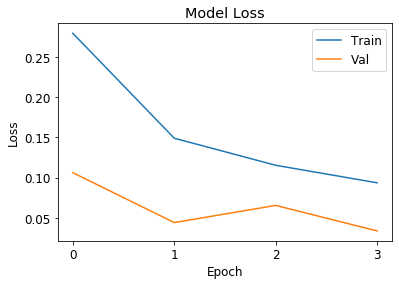

In [44]:
from matplotlib.ticker import MaxNLocator
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(model_history.history['loss'][:])
ax.plot(model_history.history['val_loss'][:])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='best')
plt.savefig("loss.svg")
plt.show()

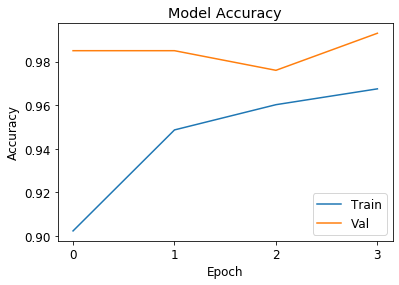

In [47]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(model_history.history['acc'][:])
ax.plot(model_history.history['val_acc'][:])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='best')
plt.savefig("acc.svg")
plt.show()

In [ ]:
"""weight_addrs = glob.glob('top_weights/*')
model.load_weights(weight_addrs[0])"""

In [33]:
test_generator = test_datagen.flow_from_directory(
        base + 'test/',
        target_size=(299, 299),
        batch_size=64,
        class_mode='categorical',
        shuffle = False)

filenames = test_generator.filenames
Y_test = test_generator.classes
nb_samples = len(filenames)

Found 1000 images belonging to 4 classes.


In [34]:
preds = model.predict_generator(test_generator, steps = 1000/64)

In [35]:
len(preds)

1000

In [36]:
Y_pred = np.argmax(preds, axis = 1)
ans = 0
for i in range(Y_test.shape[0]):
    #print(Y_test[i], Y_pred[i])
    if Y_test[i] == Y_pred[i]:
        ans = ans + 1    

print("Test Accuracy is " + str((ans/float(Y_test.shape[0]))*100))

Test Accuracy is 99.3


In [37]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [38]:
state = {0:'CNV', 1:'DME', 2:'DRUSEN', 3: 'NORMAL'}
Y_state = np.array([state[a] for a in Y_test])
Y_pred_state = np.array([state[a] for a in Y_pred])

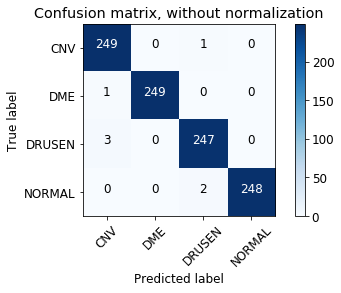

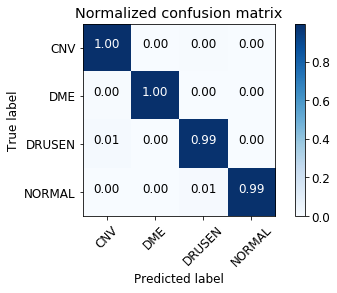

In [39]:
plt.rcParams.update({'font.size': 12})
class_names =[]
for k in range(4):
    class_names.append(state[k])
cnf_matrix = confusion_matrix(Y_state, Y_pred_state)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.savefig('conf.svg')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('nConf.svg')